# A Quick Guide to Weighted Averages

Consider the following situations:

* A vendor sets the price for their wares at...
    * `10.00` USD per unit for 9 or fewer units,
    * `9.50` USD per unit for 10-99 units, and
    * `8.00` USD per unit for 100+ units.
* A course rubric states...
    * quizzes and homeworks count for `10%`,
    * each exam counts for `20%`, and
    * the final counts for `40%` of a student's final grade.
* A research student needs...
    * 10 mL of `70%` acetone solution,
    * but only has `90%` and `60%` acetone.

All of the above examples are cases of weighted averages, a common method of taking averages where each contributor has a different "weight" or "importance" to the average.

So, how can we interact with weighted averages in our datasets? Consider the following example of a manufacturer listing out their cost of production.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=weighted-averages" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import pandas as pd
import atoti as tt

session = tt.Session.start()
supplycost = session.read_pandas(
    pd.DataFrame(
        columns=["Ord", "Itm", "Qty", "Cst"],
        data=[
            (1123123, "Lumber Nails, pounds", 10, 14.00),
            (1123123, "Paint, gals", 5, 32.00),
            (1123123, "Pressure Treated Planks", 800, 9100.00),
            (1342342, "Pressure Treated Planks", 300, 4100.00),
            (1342342, "Polycarbonate Sheets", 100, 302.00),
            (3134910, "Paint, gals", 10, 80.00),
            (7423123, "Pressure Treated Planks", 1600, 12500.00),
            (9472872, "Lumber Nails, pounds", 10, 12.00),
        ],
    ),
    table_name="supplycost",
    keys=["Ord", "Itm"],
)

supplycost.head()

,,Qty,Cst
Ord,Itm,,
1123123,"Lumber Nails, pounds",10,14.0
9472872,"Lumber Nails, pounds",10,12.0
1123123,"Paint, gals",5,32.0
7423123,Pressure Treated Planks,1600,12500.0
1123123,Pressure Treated Planks,800,9100.0


In this example, a few of the items needed to manufacture the company's wares were purchased multiple times--but each time the unit price was different.  This could have happened because the vendor changed their prices, the manufacturer bought a different quantity and thus were eligible for a different price, or perhaps the manufacturer chose a different vendor.

Determining the overall cost of manufacturing is straight forward, but what if the manufacturer wants to dig a bit deeper into the costs, and determine things like what was the average cost of lumber per item manufactured?

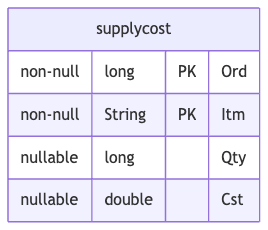

In [2]:
cube = session.create_cube(supplycost, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

session.tables.schema

Let's create a quick pivot table to see what measures we have and what they look like.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
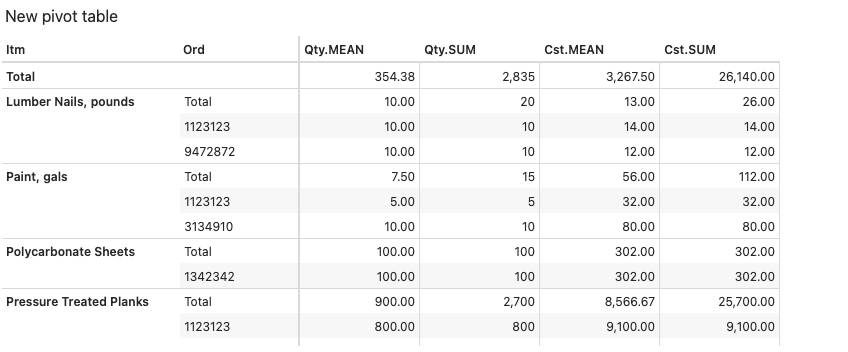

In [3]:
session.widget

Several things pop out:

* Firstly, with the exception of the `Cst.SUM` Total, none of the grand totals are sensible.  After all, paint would sold in terms of volume, bulk lumber nails in terms of weight, and planks and sheets in terms of linear length or square area.  Summing or averaging things with different units is odd.

* Secondly, the `Cst.MEAN` is only relevant if we think about it in terms of number of orders-but it does not take into account the variation of quantity in each order.

* Finally, to rectify this, we can create additional measures and replace our existing measures with new ones to better study our costs. For example, we can calculate the unit price for each item in each order.

In [4]:
m["UnitPrice"] = tt.agg.single_value(supplycost["Cst"]) / tt.agg.single_value(
    supplycost["Qty"]
)

Looking at this in our pivot table, this seems sensible.  It would not make sense to sum up the unit cost for the same item across two orders.  At best, it might make sense to compute the average at the subtotal.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
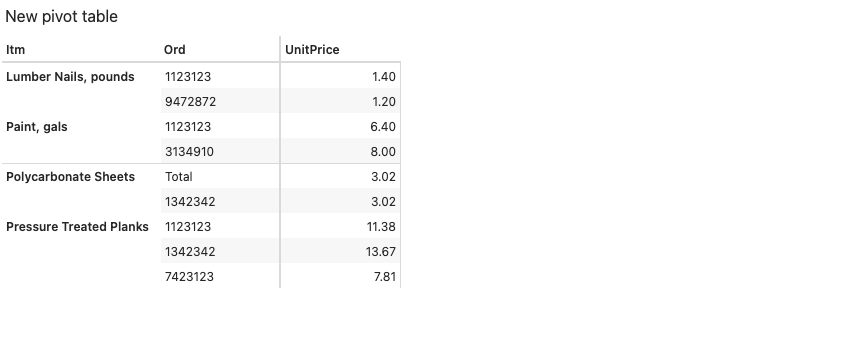

In [5]:
session.widget

While summing up the unit price may not make sense, it could make sense to determine the max or min price.  Let's create these measures, as well as a (non-weighted) average.

In [6]:
m["UnitPrice.MAX"] = tt.agg.max(
    m["UnitPrice"], scope=tt.OriginScope(levels={l["Itm"], l["Ord"]})
)
m["UnitPrice.MIN"] = tt.agg.min(
    m["UnitPrice"], scope=tt.OriginScope(levels={l["Itm"], l["Ord"]})
)

m["UnitPrice.MEAN"] = tt.agg.mean(
    m["UnitPrice"], scope=tt.OriginScope(levels={l["Itm"], l["Ord"]})
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
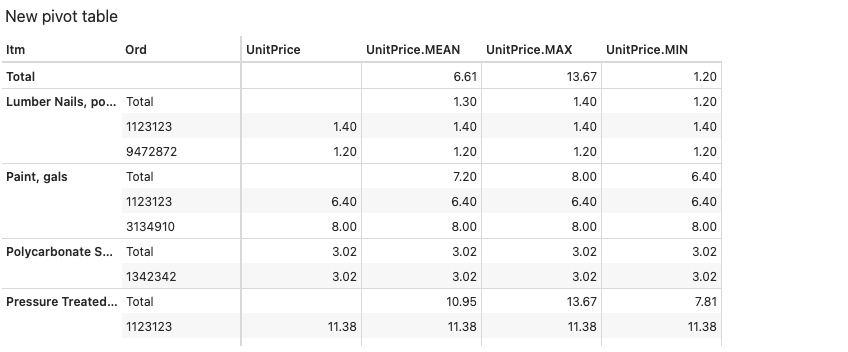

In [7]:
session.widget

We've computed the average unit price, but what about the weighted average unit price - that is, the price taking into account the different order sizes?  The average unit price is a simple average.

To compute the weighted average, we need to take the total cost for each item across orders, and divide by the overall number of units purchased for each item across orders.  This will help account, or weight, orders where a greater number or more were purchased heavier than orders of the same item where fewer or less were purchased.

In [8]:
m["UnitPrice.WA"] = tt.agg.sum(
    (m["Cst.SUM"] / m["Qty.SUM"]), scope=tt.OriginScope(levels={l["Itm"]})
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
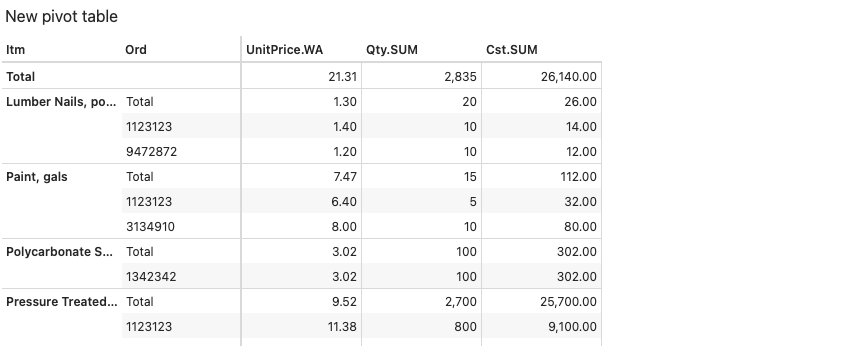

In [9]:
session.widget

And for comparison, this is not the same as the mean Unit Price!

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
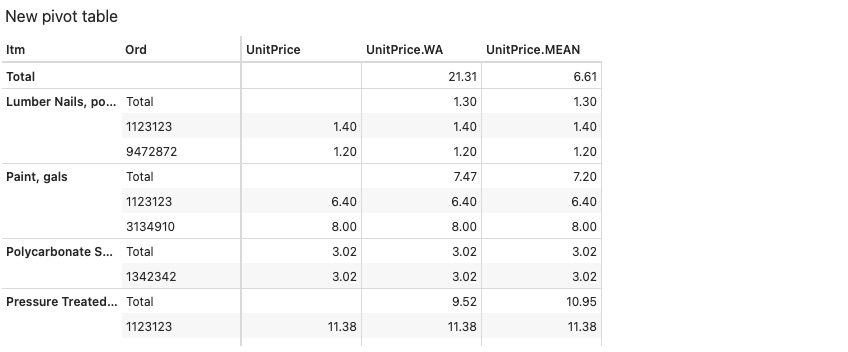

In [10]:
session.widget

A note about the newly creating measures:  it is still accurate regardless of the order of our hierarchies, allowing us to view the supply costs costs from multiple perspectives.  For example, if we wanted to determine the unit price weighted average for each item in an order (if that made sense; in this example, it is a bit odd), we can do so with the measure we already created.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
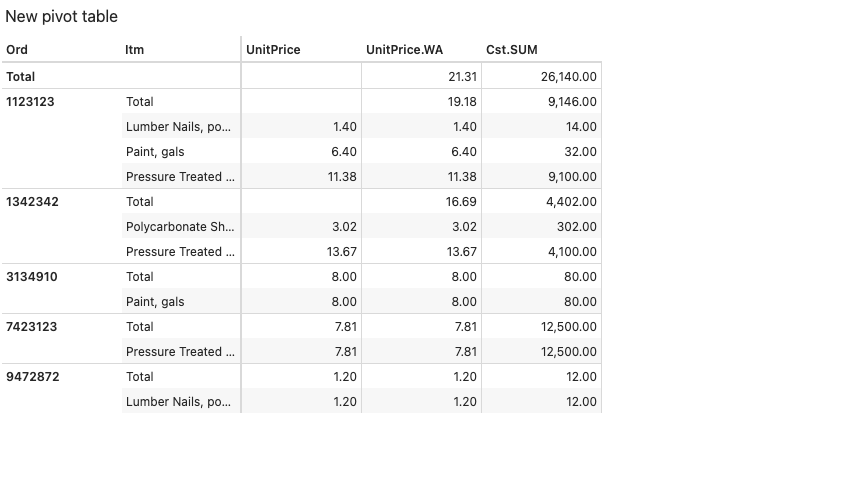

In [11]:
session.widget

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=weighted-averages" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>